In [1]:
import pandas as pd
import numpy as np
import json
import operator
import itertools 
import matplotlib.pyplot as plt
import re
import subprocess
import seaborn as sns
from scipy.stats import beta,binom,betabinom
import tikz
import pickle


## Parameters

In [33]:
#Datasets
dataDir="./datasets/"
datasetNames=[
    #"adult",
    "airport",
    "flights",
    "food",
    "Hospital",
    "ncvoter",
    "tax500k",
]


In [4]:
#Algorithms
JARDir="./algorithmJARs/"
algorithms=[
    "FastDC",
    "Hydra",
    "DCFinder",
    "ADCMiner",
    "FastADC",
]

In [5]:
#Approximation factors to be used by algorithms
aproximations=["0.00","0.00000001","0.000001","0.0001","0.01"]
aproxexp=["0","10^{-8}","10^{-6}","10^{-4}","10^{-2}"]


# Code

In [6]:
class Operator:
    def __init__(self,func,expFunc) -> None:
        self.func=func
        self.expFunc=expFunc
        self.neg=None
        self.imp=None
    def __call__(self,a,b):
        return self.func(a,b)
    def negate(self):
        return Operator(operator.invert(self.func))
    def expected(self,c1,c2):
        return self.expFunc(c1,c2)
    def __repr__(self) -> str:
        return revopmap[self]
    def __eq__(self, other: object) -> bool:
        if isinstance(other, Operator):
            return self.func==other.func
        return False
    def __hash__(self):
        fields=(self.func)
        hash_value = hash(fields)
        return hash_value

def eqExp(l,r):
    n=sum(l)**2
    return np.sum(l**2)/n
       

eq=Operator(operator.eq,eqExp)

def neExp(l,r):
    n=sum(l)
    return 1-np.sum(l**2)/n**2
ne=Operator(operator.ne,neExp)

def geExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(cumFreq))/n**2
ge=Operator(operator.ge,geExp)

def leExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(n-cumFreq+l))/n**2
le=Operator(operator.le,leExp)

def gtExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(cumFreq-l))/n**2
gt=Operator(operator.gt,gtExp)

def ltExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(n-cumFreq))/n**2
lt=Operator(operator.lt,ltExp)
operatorMap={
    "EQUAL":eq,
    "UNEQUAL":ne,
    "LESS_EQUAL":le,
    "GREATER_EQUAL":ge,
    "LESS":lt,
    "GREATER":gt
}

opmap={"==":eq,"<>":ne,">=":ge,"<=":le,">":gt,"<":lt}
revopmap={y:x for x,y in opmap.items()}

eq.neg=ne
ne.neg=eq
gt.neg=le
le.neg=gt
lt.neg=ge
ge.neg=lt

eq.imp=[ge,le,eq]
ne.imp=[ne]
gt.imp=[gt,ge,ne]
lt.imp=[lt,le,ne]
ge.imp=[ge]
le.imp=[le]


#wrong implications to avoid DCs of the sort > -> !=
eq.imp=[ge,le,eq]
ne.imp=[ne,lt,gt]
gt.imp=[gt,ge]
lt.imp=[lt,le]
ge.imp=[ge]
le.imp=[le]


class Predicate:
    def __init__(self,l:str,op:Operator,r:str) -> None:
        self.l=l
        self.r=r
        self.op=op
        self.exp=None
         

            
    
    def __repr__(self) -> str:
        return 't0.'+self.l +' '+self.op.__repr__()+' t1.'+self.r+''
    def __hash__(self):
        fields=(self.l,self.r)
        hash_value = hash(fields)
        return hash_value

    def __eq__(self, other):
        if isinstance(other, Predicate):
            sFields=(self.l,self.op,self.r)
            oFields=(other.l,other.op,other.r)
            return sFields==oFields
        return False
    def impliesPred(self,other):
        #True if predicate being false implies other being false
        return self.l==other.l and self.r==other.r and other.op.neg in self.op.neg.imp




class Dataset:
    def __init__(self,file,**args):
        self.columns=pd.read_csv(file,nrows=0).columns
        self.header=[re.match(r'([^\(\)]*)(?:\(| )([^\(\)]*)\)?',col) for col in self.columns]
        self.names=[match[1] for match in self.header]
        typeMap={'String':str,'Integer':float,'Int':float,'Double':float,'int':float,'str':str,'float':float}
        self.types={col:typeMap[match[2]] for col,match in zip(self.columns,self.header)}
        
        self.df=pd.read_csv(file,**args,dtype=self.types)
        for i,col in enumerate(self.columns):
            self.df[col]=self.df[col].astype(self.types[col])
        
    def randRows(self,n):
        ids=np.random.randint(0,len(self.df),n)
        return self.df.iloc[ids]
    def randFields(self,n):
        return pd.DataFrame({col:dfs[col].iloc[list(np.random.randint(0,len(dfs),n))].values for dfs in [self.df] for col in dfs.columns})

    def buildPLIs(self):
        self.PLI= {col:self.df.groupby(by=col).groups for col in self.df}
        self.PLILen={col:np.array([len(self.PLI[col][v])for v in self.PLI[col]]) for col in self.df}
        self.vals={col:np.array([v for v in self.PLI[col]]) for col in self.df}
    def shuffle(self):
        self.df=self.randFields(len(self.df))

    def buildPreds(self):
        self.preds=[]
        self.predMap={}
        self.colPreds=[]
        self.predCols=[]
        
        for col in self.columns:
            ops=[eq,ne] if self.types[col] ==str else [eq,ne,gt,ge,lt,le]
            self.colPreds.append([]) 
            for op in ops:
                pred=Predicate(col,op,col)
                self.predMap[(col,op,col)]=len(self.preds)
                self.predCols.append(len(self.colPreds))
                self.colPreds[-1].append(len(self.preds))
                self.preds.append(pred)
                
                
                
    
    def buildEvi(self):
        n=len(self.df)
        m=len(self.preds)
        self.eviSize=n*(n-1)

        self.evi=[None]*m
        self.predProbs=[None]*m
        
       
        for p in range(m):
            pred=self.preds[p]
            col=self.df[pred.l]
            evis=[]
            for i in range(n):
                c1=col.iloc[i]
                c2=col.iloc[i+1:n]
                evis.append(pred.op(c1,c2))
                c2=col.iloc[:i]
                evis.append(pred.op(c1,c2))

            allTPs=np.concatenate(evis)
            self.evi[p]=np.packbits(allTPs,axis=0,bitorder='little')
            self.predProbs[p]=allTPs.sum()/(n*(n-1))*2
        self.sortedPreds=sorted(range(len(self.predProbs)),key=lambda i:self.predProbs[i])
                


class DenialConstraint:
    def __init__(self,preds) -> None:
        self.preds=preds
        
    def __sub__(self,other):
        return DenialConstraint(self.preds-other.preds)
    def __le__(self,other):
        other:DenialConstraint=other
        return all([ any([p==pp for pp in other.preds]) for p in self.preds])

    def __eq__(self, value: object) -> bool:
        return self<=value and value<=self
    def __repr__(self) -> str:
        return "¬("+" ^ ".join([pred.__repr__() for pred in self.preds])+")"
    
    
    


class DenialConstraintSet:
    def __init__(self,path,dataset,dss,algorithm) -> None:        
        self.predMap={}
        self.preds=[]
        self.dss=dss
        opmap={"==":eq,"<>":ne,">=":ge,"<=":le,">":gt,"<":lt}
        def getPred(c1,op,c2):
            op=opmap[op]
            return dss.predMap[(c1,op,c2)]
        
        self.DCs=[]
        
        with open(path) as f:
            for line in f:
                line=line.strip()[2:-1] #strip !(...)
                preds=line.split('^')
                regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'
                if algorithm in ['ADCMiner','FastADC','ours']:
                    regex=r't0\.([^=><]*) (==|<>|>=|<=|>|<) t1\.([^=><]*)'
                preds = [getPred(*re.match(regex,pred.strip()).groups()) for pred in preds]
                self.DCs.append(preds)

    def buildGraph(self):
        self.root=[{},None]
        for dc in self.DCs:
            node=self.root
            for pred in sorted(dc):
                if pred not in node[0]:
                    node[0][pred]=[{},None]
                node=node[0][pred]
            node[1]=dc

    def getReduced(self):
       
        notImplied=[True]*len(self.DCs)

        def impliesDC(dc1,dc2):
            return all([any([self.dss.preds[pred].impliesPred(self.dss.preds[otherpred]) for otherpred in dc2]) for pred in dc1])

        for i,dc1 in enumerate(self.DCs):
            for j,dc2 in enumerate(self.DCs):
                if impliesDC(dc1,dc2):
                    if impliesDC(dc2,dc1):
                        notImplied[j]=notImplied[j] and j<=i
                    else:
                        notImplied[j]=False
        return [dc for i,dc in enumerate(self.DCs) if notImplied[i]]
        

<>:231: SyntaxWarning: invalid escape sequence '\.'
<>:231: SyntaxWarning: invalid escape sequence '\.'
<>:231: SyntaxWarning: invalid escape sequence '\.'
<>:231: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_671/2610641545.py:231: SyntaxWarning: invalid escape sequence '\.'
  regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'
/tmp/ipykernel_671/2610641545.py:231: SyntaxWarning: invalid escape sequence '\.'
  regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'


# Results

In [34]:
#load datasets
datasets={}
for name in datasetNames:
    print(name)
    datasets[name]=Dataset(dataDir+name+".csv",nrows=2000,encoding='unicode_escape')
    datasets[name].buildPLIs()
    datasets[name].buildPreds()
    datasets[name].buildEvi()


airport
flights
food
Hospital
ncvoter
tax500k


## Compute DC satisfactions


In [ ]:
#Compute satisfaction of accepted DCs on data
results={}
for dataset in datasetNames:
    print("Load dataset"+str(dataset))
    ds=Dataset(dataDir+dataset+".csv",nrows=2**14,encoding='unicode_escape')
    ds.buildPLIs()
    ds.buildPreds()
    ds.buildEvi()
    print("Loaded dataset "+str(dataset))
    for algorithm in algorithms[:]:
        aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm not in ['Hydra','FastDC'] else ["0.00"]
        for aprox in aproxs:        
            print("{}_{}_{}".format(algorithm,dataset,aprox))
            
            dcs=DenialConstraintSet("results/{}_{}_{}".format(algorithm,dataset,aprox),dataset,ds,algorithm)
            dcs.buildGraph()
            res={}
            def search(b,s,x,node,prob=1):
                res[s]=(np.sum(np.bitwise_count(x))/ds.eviSize,prob,node[1] is not None)
                    
                for i in range(b,len(ds.preds)):
                    if i in node[0]:
                        search(i+1,s|{i},np.bitwise_and(x,ds.evi[i]),node[0][i],prob*ds.predProbs[i])

            search(0,frozenset(),np.full((ds.eviSize//8,),255,dtype=np.uint8),dcs.root)

            results[(algorithm,dataset,aprox)]=res

In [7]:
#Save results so they can be used later.
with open("results/DCSatisfactions", 'wb') as file:
        pickle.dump(results,file)

In [39]:
#Save results so they can be used later.
with open("results/DCSatisfactions", 'rb') as file:
        results=pickle.load(file)

In [41]:
#Filter only discovered DCs instead of graph nodes
results={x: {dc:results[x][dc] for dc in results[x] if results[x][dc][2]}  for x in results}

In [42]:
len(results[('FastADC','flights','0.0001')])

133586

## Compute number of tuple pairs satisfying each node

In [8]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)))

In [ ]:
#Our results
depth=4
DCCounts={}
for dataset in datasetNames:

    
    print("Load dataset "+str(dataset))
    ds=Dataset(dataDir+dataset+".csv",nrows=2**12,encoding='unicode_escape')
    ds.buildPLIs()
    ds.buildPreds()
    ds.buildEvi()
    print("Loaded dataset "+str(dataset))
    counts={}
    
    def search(preds,cols,x):

        
        counts[preds]=np.bitwise_count(x).sum()
        if len(preds)>=depth:
             return
            
        for pred in ds.sortedPreds:
                ncol=ds.predCols[pred]
                if ncol in cols:
                    continue
                npreds=preds|{pred}
                ncols=cols|{ncol}
                if npreds in counts:
                    continue

                newx=np.bitwise_and(x,ds.evi[pred])
                    
                search(npreds,ncols,newx)

    search(frozenset(),frozenset(),np.full((ds.eviSize//8,),255,dtype=np.uint8))

    DCCounts[dataset]=counts

    

In [21]:
#Save results so they can be used later.
with open("results/DCCounts", 'wb') as file:
        pickle.dump(DCCounts,file)

In [10]:
#Save results so they can be used later.
with open("results/DCCounts", 'rb') as file:
        DCCounts=pickle.load(file)

## Compute triviality

In [10]:
yconst=0.5772156649
def y1():
    mem=[-yconst]
    def f(n):
        while len(mem)<n:
            mem.append(mem[-1]+1/len(mem))
        return mem[n-1]
    return f
y1=y1()


def y2():
    mem=[np.pi**2/6]
    def f(n):
        while len(mem)<n:
            mem.append(mem[-1]-1/len(mem)**2)
        return mem[n-1]
    return f
y2=y2()

In [12]:
#Our results
depth=4
DCResults={}
for dataset in datasetNames:
    print(dataset)
    print("Load dataset "+str(dataset))
    ds=Dataset(dataDir+dataset+".csv",nrows=2**10,encoding='unicode_escape')
    ds.buildPLIs()
    ds.buildPreds()
    ds.buildEvi()
    print("Loaded dataset "+str(dataset))
    counts=DCCounts[dataset]
    DCResult=[]
    visited=set()
    
    def search(preds,cols):
        if preds in visited:
             return
        visited.add(preds)

        
        
        if len(preds)>=depth:
             return
            
        for pred in ds.sortedPreds:
                ncol=ds.predCols[pred]
                if ncol in cols:
                    continue
                npreds=preds|{pred}
                ncols=cols|{ncol}

                a1=int(counts[npreds])
                b1=int(counts[preds])-a1

                nontrivial=True

                for subPreds in powerset(preds):
                    subPreds=frozenset(subPreds)
                    npreds2=subPreds|{pred}

                    a2=int(counts[npreds2])
                    b2=int(counts[subPreds])-a2
                    
                    u=y1(a1+1)-y1(b1+1)-y1(a2+1)+y1(b2+1)

                    s=np.sqrt(y2(a1+1)+y2(b1+1)+y2(a2+1)+y2(b2+1))

                    if u+2*s>0:
                        nontrivial=False
                        break
                if nontrivial:
                    if a1==0:
                        DCResult.append((preds,pred))
                    else:
                        search(npreds,ncols)

    search(frozenset(),frozenset())

    DCResults[dataset]=DCResult

airport
Load dataset airport
Loaded dataset airport
flights
Load dataset flights
Loaded dataset flights
food
Load dataset food
Loaded dataset food
Hospital
Load dataset Hospital
Loaded dataset Hospital
ncvoter
Load dataset ncvoter
Loaded dataset ncvoter
tax500k
Load dataset tax500k
Loaded dataset tax500k


In [13]:
#Save results so they can be used later.
with open("results/DCResults", 'wb') as file:
        pickle.dump(DCResults,file)

In [11]:
#Save results so they can be used later.
with open("results/DCResults", 'rb') as file:
        DCResults=pickle.load(file)

In [23]:
def getPred(i,ds):
    return (ds.preds[i])
for dataset in datasetNames:
    print("Load dataset "+str(dataset))
    ds=Dataset(dataDir+dataset+".csv",nrows=2**10,encoding='unicode_escape')
    ds.buildPLIs()
    ds.buildPreds()
    print("Loaded dataset "+str(dataset))
    with open("results/ours_"+dataset+"_0.00","w") as f:
        for dc in [ DenialConstraint([ getPred(p,ds) for p in preds]+[getPred(pred,ds)]) for preds,pred in DCResults[dataset]]:
            f.write(dc.__repr__()+"\n")
    

Load dataset airport
Loaded dataset airport
Load dataset flights
Loaded dataset flights
Load dataset food
Loaded dataset food
Load dataset Hospital
Loaded dataset Hospital
Load dataset ncvoter
Loaded dataset ncvoter
Load dataset tax500k
Loaded dataset tax500k


In [39]:
for dataset in datasetNames:
    print("Load dataset "+str(dataset))
    ours=DenialConstraintSet("results/ours_{}_0.00".format(dataset),dataset,datasets[dataset],"ours")
    reduced=ours.getReduced()
    with open("results/ours_"+dataset+"_0.00","w") as f:
        for dc in [ DenialConstraint([ ours.dss.preds[p] for p in preds]) for preds in reduced]:
            #print(dc.__repr__()+"\n")
            f.write(dc.__repr__()+"\n")
    

Load dataset airport
Load dataset flights
Load dataset food
Load dataset Hospital
Load dataset ncvoter
Load dataset tax500k


In [7]:
for dataset in datasetNames:
    print("Load dataset "+str(dataset))
    golden=DenialConstraintSet("results/ours_{}_0.00".format(dataset),dataset,datasets[dataset],"ours")
    reduced=golden.getReduced()
    with open("goldenDCs/{}".format(dataset),"w") as f:
        for dc in [ DenialConstraint([ golden.dss.preds[p] for p in preds]) for preds in reduced]:
            #print(dc.__repr__()+"\n")
            f.write(dc.__repr__()+"\n")
    

Load dataset airport
Load dataset flights
Load dataset food
Load dataset Hospital
Load dataset ncvoter
Load dataset SPStock
Load dataset tax500k


In [10]:
filteredResults={}
for ex in results:
    alg,dataset,ap=ex
    if dataset not in datasetNames:
        continue
    ours=DenialConstraintSet("results/ours_{}_0.00".format(dataset),dataset,datasets[dataset],"ours")
    filteredResults[ex] = {dc:results[ex][dc] for dc in results[ex] if results[ex][dc][2] and dc in {frozenset(dc2) for dc2 in ours.DCs}}
results=filteredResults

## Get tikz code for figures

In [70]:
# DC Lengths Vertical
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(algorithms)
imgHeight=datasetHeight*len(datasetNames)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2

buckets=8
legendBuckedWidth=0.2
legendBucketSpace=0.4

colors=[sns.color_palette(palette='Accent')[i] for i in range(buckets)]
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for d,dataset in enumerate(datasetNames):
        drawDataset(pic,d,d*datasetHeight)
    drawLegend(pic)

def drawDataset(pic,d,y):
    for a,algorithm in enumerate(algorithms):
        drawAlgorithm(pic,d,a,a*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(datasetNames[d],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')

    pic.draw((-0.1,y+barHOffset),tikz.node("\\tiny 0\\%",anchor=' east'))
    pic.draw((-0.1,y-barHOffset+datasetHeight),tikz.node("\\tiny "+"100\\%",anchor=' east'))



def drawAlgorithm(pic,d,a,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth,y)
        if a<2:
            break

    if d==0:
        pic.draw((x+algoWidth/2,y-0.8),tikz.node(algorithms[a]))


def drawAprox(pic,d,a,ap,x,y):

    res=results[(algorithms[a],datasetNames[d],aproximations[ap])]
    bins=np.zeros((buckets,))
    for dc in res:
        l=len(dc)-1
        l=min(l,buckets-1)
        bins[l]+=1
    
    bins=np.cumsum(bins)
    bins=bins/bins[-1]
    bins= np.nan_to_num(bins,nan=0)
    barY=0
    
    for i in range(len(bins)):
        pic.definecolor("tmp",'RGB',",".join([str(255*x) for x in colors[i]]))
        pic.draw((x+barOffset,y+barHOffset+barY*barHeight),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+bins[i]*barHeight)),fill='tmp')
        barY=bins[i]


    if d==0  :
        pic.draw((x+barWidth/2,y-0.3),tikz.node("\\tiny$"+aproxexp[ap]+"$",rotate='-90'))


def drawLegend(pic):
    x=imgWidth/2
    
    legendwidth=buckets*legendBuckedWidth+ (buckets+1)*legendBucketSpace
    legendHeight=legendBucketSpace*2+legendBuckedWidth+0.5
    y=imgHeight+0.2+ legendHeight

    pic.draw((x-legendwidth/2,y),tikz.rectangle((x+legendwidth/2,y-legendHeight)),color='black')
    r=legendBuckedWidth
    for i in range(buckets):
        xx=x-legendwidth/2+legendBucketSpace+legendBuckedWidth/2+(legendBucketSpace+legendBuckedWidth)*i
        yy=y-legendBucketSpace-legendBuckedWidth/2
        pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[i]]))
        pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
        txt=str(i+1)
        if i==buckets-1:
            txt+="+"
        pic.draw((xx-r,yy-0.5),tikz.node(txt,anchor='west'))

    

In [28]:
# DC Lengths Horizontal
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(datasetNames)
imgHeight=datasetHeight*len(algorithms)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2

buckets=8
legendBuckedWidth=0.2
legendBucketSpace=0.4

colors=[sns.color_palette(palette='Accent')[i] for i in range(buckets)]
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for a,dataset in enumerate(algorithms):
        drawAlgorithm(pic,a,(len(algorithms)-1-a)*datasetHeight)
    drawLegend(pic)

def drawAlgorithm(pic,a,y):
    for d,_ in  enumerate(datasetNames):
        drawDataset(pic,a,d,d*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(algorithms[a],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')

    pic.draw((-0.1,y+barHOffset),tikz.node("\\tiny 0\\%",anchor=' east'))
    pic.draw((-0.1,y-barHOffset+datasetHeight),tikz.node("\\tiny "+"100\\%",anchor=' east'))



def drawDataset(pic,a,d,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth,y)
        if a<2:
            break

    if a==len(algorithms)-1:
        pic.draw((x+algoWidth/2,y-0.8),tikz.node(datasetNames[d]))


def drawAprox(pic,d,a,ap,x,y):

    res=results[(algorithms[a],datasetNames[d],aproximations[ap])]
    bins=np.zeros((buckets,))
    for dc in res:
        l=len(dc)-1
        l=min(l,buckets-1)
        bins[l]+=1
    
    bins=np.cumsum(bins)
    bins=bins/bins[-1]
    bins= np.nan_to_num(bins,nan=0)
    barY=0
    
    for i in range(len(bins)):
        pic.definecolor("tmp",'RGB',",".join([str(255*x) for x in colors[i]]))
        pic.draw((x+barOffset,y+barHOffset+barY*barHeight),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+bins[i]*barHeight)),fill='tmp')
        barY=bins[i]


    if a==len(algorithms)-1  :
        pic.draw((x+barWidth/2,y-0.3),tikz.node("\\tiny$"+aproxexp[ap]+"$",rotate='-90'))


def drawLegend(pic):
    
    
    legendwidth=buckets*legendBuckedWidth+ (buckets+1)*legendBucketSpace
    legendHeight=legendBucketSpace*2+legendBuckedWidth+0.6
    legendwidth,legendHeight=legendHeight,legendwidth
    x=imgWidth + 0.2 +legendwidth/2
    y=imgHeight/2 - legendHeight/2

    pic.draw((x-legendBuckedWidth/2-legendBucketSpace/2,y),tikz.rectangle((x+legendwidth/2,y+legendHeight)),color='black')
    r=legendBuckedWidth
    for i in range(buckets):
        yy=y+legendBucketSpace+legendBuckedWidth/2+(legendBucketSpace+legendBuckedWidth)*i
        xx=x
        pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[i]]))
        pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
        txt=str(i+1)
        if i==buckets-1:
            txt+="+"
        pic.draw((xx+r,yy),tikz.node(txt,anchor='west'))

    

In [45]:
# DC precision Vertical
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(algorithms)
imgHeight=datasetHeight*len(datasetNames)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2

buckets=2
legendBuckedWidth=0.2
legendBucketSpace=0.4

colors=[(0.9,0,0),(0,0.9,0)]
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for d,dataset in enumerate(datasetNames):
        drawDataset(pic,d,d*datasetHeight)
    #drawLegend(pic)

def drawDataset(pic,d,y):
    for a,algorithm in enumerate(algorithms):
        drawAlgorithm(pic,d,a,a*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(datasetNames[d],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')

    sizes=[ len(results[(aa,datasetNames[d],aapp)]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)

    pic.draw((-0.1,y+barHOffset),tikz.node("\\tiny 0",anchor=' east'))
    pic.draw((-0.1,y-barHOffset+datasetHeight),tikz.node("\\tiny "+str(maxSize),anchor=' east'))



def drawAlgorithm(pic,d,a,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth,y)
        if a<2:
            break

    if d==0:
        pic.draw((x+algoWidth/2,y-0.8),tikz.node(algorithms[a]))


def drawAprox(pic,d,a,ap,x,y):
    golden=DenialConstraintSet("goldenDCs/{}".format(datasetNames[d]),datasetNames[d],datasets[datasetNames[d]],"ours")
    golden=[frozenset(x) for x in golden.DCs]
    res=results[(algorithms[a],datasetNames[d],aproximations[ap])]

    sizes=[ len(results[(aa,datasetNames[d],aapp)]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)
    size=len(res)
    bins=np.zeros((buckets,))
    for dc in res:
        if dc in golden:
            bins[1]+=1
        else:
            bins[0]+=1
    
    bins=np.cumsum(bins)
    bins=bins/bins[-1]
    bins=bins*size/maxSize
    bins= np.nan_to_num(bins,nan=0)
    barY=0
    
    for i in range(len(bins)):
        pic.definecolor("tmp",'RGB',",".join([str(255*x) for x in colors[i]]))
        
        pic.draw((x+barOffset,y+barHOffset+barY*barHeight),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+bins[i]*barHeight)),fill='tmp')
        barY=bins[i]


    if d==0  :
        pic.draw((x+barWidth/2,y-0.3),tikz.node("\\tiny$"+aproxexp[ap]+"$",rotate='-90'))


def drawLegend(pic):
    x=imgWidth/2
    
    legendwidth=buckets*legendBuckedWidth+ (buckets+1)*legendBucketSpace
    legendHeight=legendBucketSpace*2+legendBuckedWidth+0.5
    y=imgHeight+0.2+ legendHeight

    pic.draw((x-legendwidth/2,y),tikz.rectangle((x+legendwidth/2,y-legendHeight)),color='black')
    r=legendBuckedWidth
    for i in range(buckets):
        xx=x-legendwidth/2+legendBucketSpace+legendBuckedWidth/2+(legendBucketSpace+legendBuckedWidth)*i
        yy=y-legendBucketSpace-legendBuckedWidth/2
        pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[i]]))
        pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
        txt=str(i)
        if i==buckets-1:
            txt+="+"
        pic.draw((xx-r,yy-0.5),tikz.node(txt,anchor='west'))

    

In [31]:
# DC precision Horizontal
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(datasetNames)
imgHeight=datasetHeight*len(algorithms)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2

buckets=2
legendBuckedWidth=0.2
legendBucketSpace=0.4


colors=[(0.9,0,0),(0,0.9,0)]
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for a,dataset in enumerate(algorithms):
        drawAlgorithm(pic,a,(len(algorithms)-1-a)*datasetHeight)
    #drawLegend(pic)

def drawAlgorithm(pic,a,y):
    for d,_ in  enumerate(datasetNames):
        drawDataset(pic,a,d,d*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(algorithms[a],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')

    pic.draw((-0.1,y+barHOffset),tikz.node("\\tiny 0\\%",anchor=' east'))
    pic.draw((-0.1,y-barHOffset+datasetHeight),tikz.node("\\tiny "+"100\\%",anchor=' east'))



def drawDataset(pic,a,d,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth,y)
        if a<2:
            break

    if a==len(algorithms)-1:
        pic.draw((x+algoWidth/2,y-0.8),tikz.node(datasetNames[d]))


def drawAprox(pic,d,a,ap,x,y):
    golden=DenialConstraintSet("goldenDCs/{}".format(datasetNames[d]),datasetNames[d],datasets[datasetNames[d]],"ours")
    golden=[frozenset(x) for x in golden.DCs]
    res=results[(algorithms[a],datasetNames[d],aproximations[ap])]

    sizes=[ len(results[(aa,datasetNames[d],aapp)]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)
    size=len(res)
    bins=np.zeros((buckets,))
    for dc in res:
        if dc in golden:
            bins[1]+=1
        else:
            bins[0]+=1
    
    bins=np.cumsum(bins)
    bins=bins/bins[-1]
    #bins=bins*size/maxSize
    bins= np.nan_to_num(bins,nan=0)
    barY=0
    
    for i in range(len(bins)):
        pic.definecolor("tmp",'RGB',",".join([str(255*x) for x in colors[i]]))
        
        pic.draw((x+barOffset,y+barHOffset+barY*barHeight),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+bins[i]*barHeight)),fill='tmp')
        barY=bins[i]



    if a==len(algorithms)-1  :
        pic.draw((x+barWidth/2,y-0.3),tikz.node("\\tiny$"+aproxexp[ap]+"$",rotate='-90'))


def drawLegend(pic):
    x=imgWidth/2
    
    legendwidth=buckets*legendBuckedWidth+ (buckets+1)*legendBucketSpace
    legendHeight=legendBucketSpace*2+legendBuckedWidth+0.5
    y=imgHeight+0.2+ legendHeight

    pic.draw((x-legendwidth/2,y),tikz.rectangle((x+legendwidth/2,y-legendHeight)),color='black')
    r=legendBuckedWidth
    for i in range(buckets):
        xx=x-legendwidth/2+legendBucketSpace+legendBuckedWidth/2+(legendBucketSpace+legendBuckedWidth)*i
        yy=y-legendBucketSpace-legendBuckedWidth/2
        pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[i]]))
        pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
        txt=str(i+1)
        if i==buckets-1:
            txt+="+"
        pic.draw((xx-r,yy-0.5),tikz.node(txt,anchor='west'))

    

In [72]:
# DC independence Vertical
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(algorithms)
imgHeight=datasetHeight*len(datasetNames)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2

buckets=2
legendBuckedWidth=0.2
legendBucketSpace=0.4

colors=[(0.9,0,0),(0,0.9,0)]
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for d,dataset in enumerate(datasetNames):
        drawDataset(pic,d,d*datasetHeight)
    #drawLegend(pic)

def drawDataset(pic,d,y):
    for a,algorithm in enumerate(algorithms):
        drawAlgorithm(pic,d,a,a*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(datasetNames[d],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')

    sizes=[ len(results[(aa,datasetNames[d],aapp)]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)

    pic.draw((-0.1,y+barHOffset),tikz.node("\\tiny 0",anchor=' east'))
    pic.draw((-0.1,y-barHOffset+datasetHeight),tikz.node("\\tiny "+str(maxSize),anchor=' east'))



def drawAlgorithm(pic,d,a,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth,y)
        if a<2:
            break

    if d==0:
        pic.draw((x+algoWidth/2,y-0.8),tikz.node(algorithms[a]))


def drawAprox(pic,d,a,ap,x,y):
    golden=DenialConstraintSet("goldenDCs/{}".format(datasetNames[d]),datasetNames[d],datasets[datasetNames[d]],"ours")
    golden=[frozenset(x) for x in golden.DCs]
    res=results[(algorithms[a],datasetNames[d],aproximations[ap])]

    sizes=[ len([x for x in results[(aa,datasetNames[d],aapp)] if len(x)>1]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)
    size=len([x for x in res if len(x)>1])
    bins=np.zeros((buckets,))
    for dc in res:
        if len(dc)==1:
            continue
        jointProb=res[dc][0]
        indepProb=res[dc][1]
        n=2**14
        pval=binom.cdf(jointProb*(n*(n-1)),n*(n-1),indepProb)
        if pval<0.01:
            bins[1]+=1
        else:
            bins[0]+=1
    
    bins=np.cumsum(bins)
    if bins[-1]>0:
        bins=bins/bins[-1]
        bins=bins*size/maxSize
        bins= np.nan_to_num(bins,nan=0)
        barY=0
        
        for i in range(len(bins)):
            pic.definecolor("tmp",'RGB',",".join([str(255*x) for x in colors[i]]))
            
            pic.draw((x+barOffset,y+barHOffset+barY*barHeight),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+bins[i]*barHeight)),fill='tmp')
            barY=bins[i]


    if d==0  :
        pic.draw((x+barWidth/2,y-0.3),tikz.node("\\tiny$"+aproxexp[ap]+"$",rotate='-90'))


def drawLegend(pic):
    x=imgWidth/2
    
    legendwidth=buckets*legendBuckedWidth+ (buckets+1)*legendBucketSpace
    legendHeight=legendBucketSpace*2+legendBuckedWidth+0.5
    y=imgHeight+0.2+ legendHeight

    pic.draw((x-legendwidth/2,y),tikz.rectangle((x+legendwidth/2,y-legendHeight)),color='black')
    r=legendBuckedWidth
    for i in range(buckets):
        xx=x-legendwidth/2+legendBucketSpace+legendBuckedWidth/2+(legendBucketSpace+legendBuckedWidth)*i
        yy=y-legendBucketSpace-legendBuckedWidth/2
        pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[i]]))
        pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
        txt=str(i)
        if i==buckets-1:
            txt+="+"
        pic.draw((xx-r,yy-0.5),tikz.node(txt,anchor='west'))

    

In [71]:
pic = tikz.Picture()

image(pic)
#pic.demo(dpi=100)
print(pic.code())

\begin{tikzpicture}
\definecolor{tmp}{RGB}{127.0,201.0,127.0}
\draw[fill=tmp] (0.248,0.1) rectangle (0.472,0.14286);
\definecolor{tmp}{RGB}{190.0,174.0,212.0}
\draw[fill=tmp] (0.248,0.14286) rectangle (0.472,0.95714);
\definecolor{tmp}{RGB}{253.0,192.0,134.0}
\draw[fill=tmp] (0.248,0.95714) rectangle (0.472,1.38571);
\definecolor{tmp}{RGB}{255.0,255.0,153.0}
\draw[fill=tmp] (0.248,1.38571) rectangle (0.472,1.9);
\definecolor{tmp}{RGB}{56.0,108.0,176.0}
\draw[fill=tmp] (0.248,1.9) rectangle (0.472,1.9);
\definecolor{tmp}{RGB}{240.0,2.0,127.0}
\draw[fill=tmp] (0.248,1.9) rectangle (0.472,1.9);
\definecolor{tmp}{RGB}{191.0,91.0,22.999999999999996}
\draw[fill=tmp] (0.248,1.9) rectangle (0.472,1.9);
\definecolor{tmp}{RGB}{102.0,102.0,102.0}
\draw[fill=tmp] (0.248,1.9) rectangle (0.472,1.9);
\draw (0.312,-0.3) node[rotate=-90] {\tiny$0$};
\draw (1,-0.8) node {FastDC};
\definecolor{tmp}{RGB}{127.0,201.0,127.0}
\draw[fill=tmp] (2.248,0.1) rectangle (2.472,0.14286);
\definecolor{tmp}{RGB}{190.0

# Probability under independence evolution as data increases

FastADC_tax500k_0.00_500
FastADC_tax500k_0.00_1000
FastADC_tax500k_0.00_1500
FastADC_tax500k_0.00_2000
FastADC_tax500k_0.00_2500
FastADC_tax500k_0.00_3000
FastADC_tax500k_0.00_3500
FastADC_tax500k_0.00_4000
FastADC_tax500k_0.00_4500
FastADC_tax500k_0.00_5000
FastADC_tax500k_0.00_5500
FastADC_tax500k_0.00_6000
FastADC_tax500k_0.00_6500
FastADC_tax500k_0.00_7000
FastADC_tax500k_0.00_7500
FastADC_tax500k_0.00_8000
FastADC_tax500k_0.00_8500
FastADC_tax500k_0.00_9000
FastADC_tax500k_0.00_9500
FastADC_tax500k_0.00_10000
FastADC_tax500k_0.00_10500
FastADC_tax500k_0.00_11000
FastADC_tax500k_0.00_11500
FastADC_tax500k_0.00_12000
FastADC_tax500k_0.00_12500
FastADC_tax500k_0.00_13000
FastADC_tax500k_0.00_13500
FastADC_tax500k_0.00_14000
FastADC_tax500k_0.00_14500
FastADC_tax500k_0.00_15000
FastADC_tax500k_0.00_15500
FastADC_tax500k_0.00_16000
FastADC_tax500k_0.00_16500
FastADC_tax500k_0.00_17000
FastADC_tax500k_0.00_17500
FastADC_tax500k_0.00_18000
FastADC_tax500k_0.00_18500
FastADC_tax500k_0.00_

/tmp/ipykernel_671/2160559160.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax=sns.lineplot(x=range(500,20500,500),y=[ np.log(1/x**2)+7 for x in range(500,20500,500)],palette='gray',linestyle='--')


[Text(0.5, 0, 'Number of tuples'), Text(0, 0.5, '$log(e(\\varphi))$')]

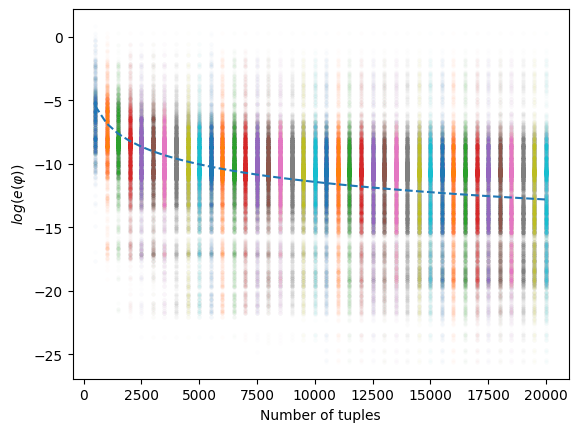

In [105]:
allVals={}
dataset="tax500k"
algorithm=algorithms[-1]
aprox=aproximations[0]
for nrows in range(500,20500,500):
    

    print("{}_{}_{}_{}".format(algorithm,dataset,aprox,nrows))

    dcs=DenialConstraintSet("results/{}_{}_{}_{}".format(algorithm,dataset,aprox,nrows),dataset,datasets[dataset],algorithm)
    dcs.buildGraph()
    res=[]
    def search(b,s,node,prob=1):
        if node[1] is not None:
            if prob>0:
                res.append(np.log(prob))
            else:
                res.append(-25)
            
        for i in range(b,len(datasets[dataset].preds)):
            if i in node[0]:
                search(i+1,s|{i},node[0][i],prob*datasets[dataset].predProbs[i])

    search(0,frozenset(),dcs.root)
    sns.scatterplot(x=nrows,y=res,s=10,alpha=0.01)

ax=sns.lineplot(x=range(500,20500,500),y=[ np.log(1/x**2)+7 for x in range(500,20500,500)],palette='gray',linestyle='--')
ax.set(xlabel="Number of tuples",ylabel="$log(e(\\varphi))$")

# Test
